# NO2

The [NO2](https://www.openml.org/search?type=data&sort=version&status=any&order=asc&exact_name=no2&id=547) is a subsample of 500 observations from a data set that originate in a study where air pollution at a road is related to traffic volume and meteorological variables, collected by the Norwegian Public Roads Administration. The response variable (column 1) consist of hourly values of the logarithm of the concentration of NO2 (particles), measured at Alnabru in Oslo, Norway, between October 2001 and August 2003.

The predictor variables (columns 2 to 8) are the logarithm of the number of cars per hour, temperature 2 meter above ground (degree C), wind speed (meters/second), the temperature difference between 25 and 2 meters above ground (degree C), wind direction (degrees between 0 and 360), hour of day and day number from October 1. 2001.

In [1]:
import effector
import numpy as np
import tensorflow as tf
from tensorflow import keras
import random

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

/Users/dimitriskyriakopoulos/Documents/ath/Effector/Code/eff-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocess the data

In [2]:
import openml

no2 = openml.datasets.get_dataset(547)

X, y, categorical_indicator, attribute_names = no2.get_data(
    target=no2.default_target_attribute
)

In [3]:
X.head()

,cars_per_hour,temperature_at_2m,wind_speed,temperature_diff_2m_25m,wind_direction,hour_of_day,day
0,7.69120,9.2,4.8,-0.1,74.4,20,600
1,7.69894,6.4,3.5,-0.3,56.0,14,196
2,4.81218,-3.7,0.9,-0.1,281.3,4,513
3,6.95177,-7.2,1.7,1.2,74.0,23,143
4,7.51806,-1.3,2.6,-0.1,65.0,11,115


In [4]:
print("Design matrix shape: {}".format(X.shape))
print("---------------------------------")
for col_name in X.columns:
    print("Feature: {:15}, unique: {:4d}, Mean: {:6.2f}, Std: {:6.2f}, Min: {:6.2f}, Max: {:6.2f}".format(col_name, len(X[col_name].unique()), X[col_name].mean(), X[col_name].std(), X[col_name].min(), X[col_name].max()))
    
print("\nTarget shape: {}".format(y.shape))
print("---------------------------------")
print("Target: {:15}, unique: {:4d}, Mean: {:6.2f}, Std: {:6.2f}, Min: {:6.2f}, Max: {:6.2f}".format("no2_concentration", len(y.unique()), y.mean(), y.std(), y.min(), y.max()))

Design matrix shape: (500, 7)
---------------------------------
Feature: cars_per_hour  , unique:  464, Mean:   6.97, Std:   1.09, Min:   4.13, Max:   8.35
Feature: temperature_at_2m, unique:  223, Mean:   0.85, Std:   6.52, Min: -18.60, Max:  21.10
Feature: wind_speed     , unique:   78, Mean:   3.06, Std:   1.78, Min:   0.30, Max:   9.90
Feature: temperature_diff_2m_25m, unique:   61, Mean:   0.15, Std:   1.07, Min:  -5.40, Max:   4.30
Feature: wind_direction , unique:  373, Mean: 143.37, Std:  86.51, Min:   2.00, Max: 359.00
Feature: hour_of_day    , unique:   24, Mean:  12.38, Std:   6.80, Min:   1.00, Max:  24.00
Feature: day            , unique:  287, Mean: 310.47, Std: 200.98, Min:  32.00, Max: 608.00

Target shape: (500,)
---------------------------------
Target: no2_concentration, unique:  385, Mean:   3.70, Std:   0.75, Min:   1.22, Max:   6.40


In [5]:
def preprocess(X, y):
    # Standarize X
    X_df = X
    x_mean = X_df.mean()
    x_std = X_df.std()
    X_df = (X_df - X_df.mean()) / X_df.std()

    # Standarize Y
    Y_df = y
    y_mean = Y_df.mean()
    y_std = Y_df.std()
    Y_df = (Y_df - Y_df.mean()) / Y_df.std()
    return X_df, Y_df, x_mean, x_std, y_mean, y_std

# shuffle and standarize all features
X_df, Y_df, x_mean, x_std, y_mean, y_std = preprocess(X, y)

In [6]:
def split(X_df, Y_df):
    # shuffle indices
    indices = X_df.index.tolist()
    np.random.shuffle(indices)
    
    # data split
    train_size = int(0.8 * len(X_df))
    
    X_train = X_df.iloc[indices[:train_size]]
    Y_train = Y_df.iloc[indices[:train_size]]
    X_test = X_df.iloc[indices[train_size:]]
    Y_test = Y_df.iloc[indices[train_size:]]
    
    return X_train, Y_train, X_test, Y_test

# train/test split
X_train, Y_train, X_test, Y_test = split(X_df, Y_df)


## Fit a Neural Network

We train a deep fully-connected Neural Network with 3 hidden layers for \(10\) epochs. 
The model achieves a root mean squared error on the test of about $0.7$ units.

In [7]:
# Train - Evaluate - Explain a neural network
model = keras.Sequential([
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae", keras.metrics.RootMeanSquaredError()])
model.fit(X_train, Y_train, batch_size=512, epochs=10, verbose=1)
model.evaluate(X_train, Y_train, verbose=1)
model.evaluate(X_test, Y_test, verbose=1)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step - loss: 0.9584 - mae: 0.7906 - root_mean_squared_error: 0.9790
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6712 - mae: 0.6472 - root_mean_squared_error: 0.8192
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.5145 - mae: 0.5716 - root_mean_squared_error: 0.7173
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4573 - mae: 0.5309 - root_mean_squared_error: 0.6763
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4320 - mae: 0.5061 - root_mean_squared_error: 0.6572
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4075 - mae: 0.4871 - root_mean_squared_error: 0.6384
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3981 - mae: 0.4815 - root_mean_squared_error: 0.6309
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3882 - mae: 0.4777 - root_mean_squared_error: 0.6231
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3707 - mae: 0.4679 - root_mean_squared_error

[0.4984276592731476, 0.5615400075912476, 0.7059940695762634]

## Explain

We will focus on the feature `wind_speed` (wind speed) because its global effect is quite heterogeneous and the heterogeneity can be further explained using regional effects.

In [8]:
def model_jac(x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        pred = model(x_tensor)
        grads = t.gradient(pred, x_tensor)
    return grads.numpy()

def model_forward(x):
    return model(x).numpy().squeeze()

In [9]:
scale_y = {"mean": y_mean, "std": y_std}
scale_x_list =[{"mean": x_mean.iloc[i], "std": x_std.iloc[i]} for i in range(len(x_mean))]
feature_names = X_df.columns.to_list()
target_name = "no2_concentration"
y_limits=(2.5,5.5)
dy_limits = (-0.3,0.1)
foi = 2

## Global Effect  

**Overview of All Features**

We start by examining all features. Feature effect methods are generally more meaningful for numerical features. To compare effects across features more easily, we standardize the `y_limits`.  

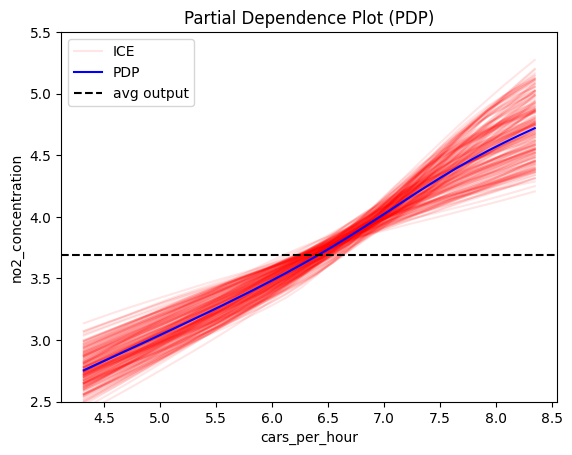

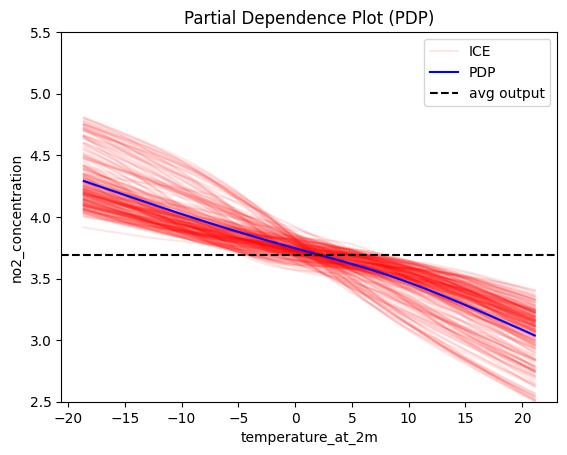

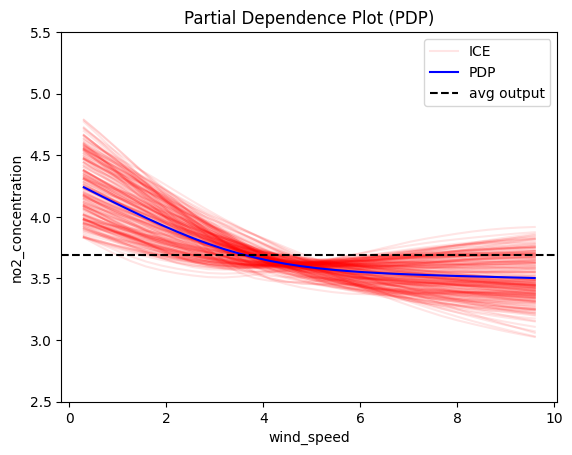

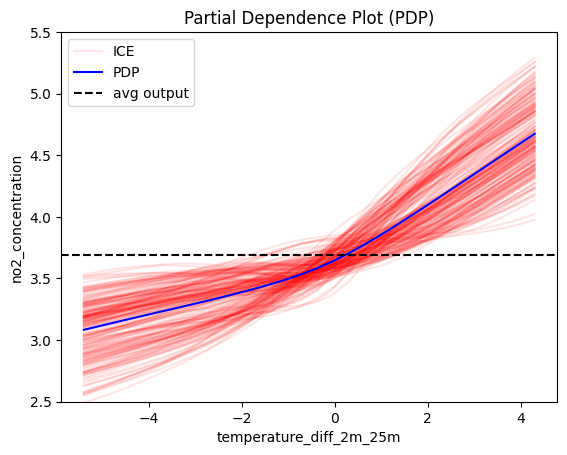

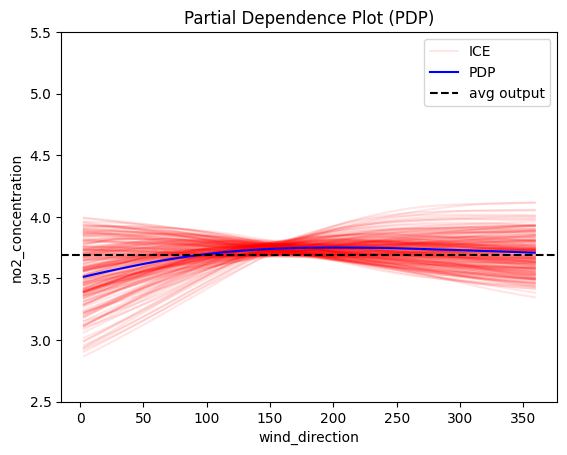

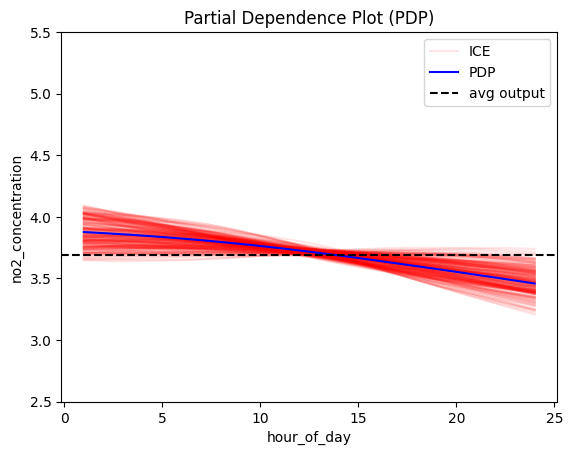

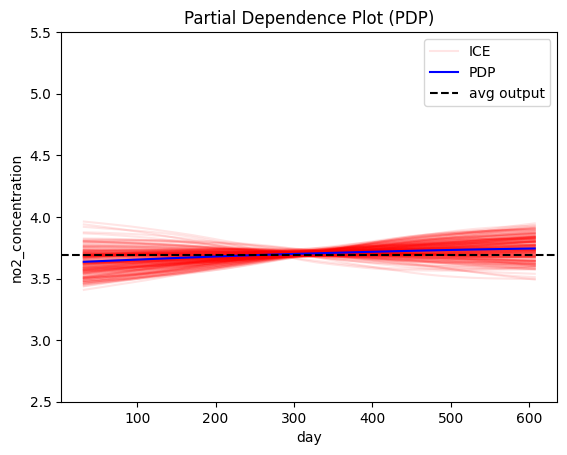

In [10]:
pdp = effector.PDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, target_name=target_name, nof_instances=2000)
for i in range(len(feature_names)):
    pdp.plot(feature=i, centering=True, scale_x=scale_x_list[i], scale_y=scale_y, show_avg_output=True, nof_ice=200, y_limits=y_limits)

In [ ]:
y_limits = (3,4.5)

### PDP 

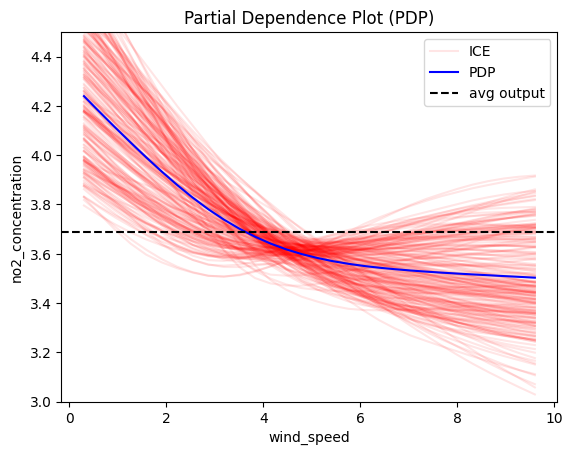

In [24]:
pdp = effector.PDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, target_name=target_name, nof_instances=5000)
pdp.plot(feature=foi, centering=True, scale_x=scale_x_list[foi], scale_y=scale_y, show_avg_output=True, nof_ice=200, y_limits=y_limits)

### RHALE

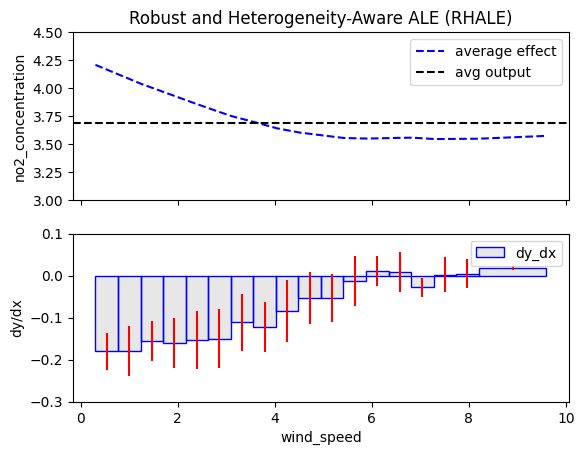

In [35]:
rhale = effector.RHALE(data=X_train.to_numpy(), model=model_forward, model_jac=model_jac, feature_names=feature_names, target_name=target_name)
rhale.plot(feature=foi, heterogeneity="std", centering=True, scale_x=scale_x_list[foi], scale_y=scale_y, show_avg_output=True, y_limits=y_limits, dy_limits=dy_limits)

ExactExplainer explainer: 401it [01:01,  5.36it/s]                         
/Users/dimitriskyriakopoulos/Documents/ath/Effector/Code/effector-git/effector/effector/global_effect_shap.py:469: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.feature_effect["feature_" + str(feature)]["spline_std"](x))


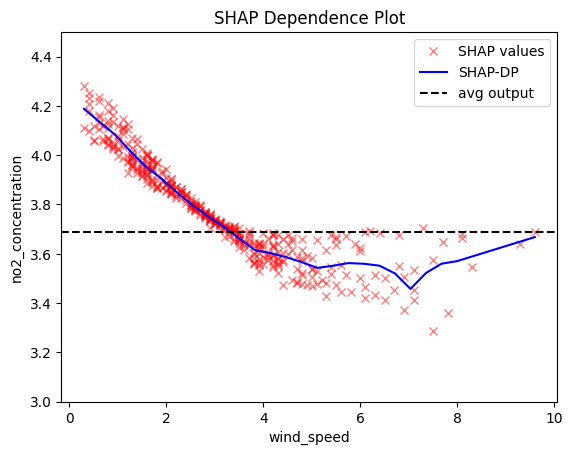

In [26]:
shap_dp = effector.ShapDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, target_name=target_name, nof_instances=500)
shap_dp.plot(feature=foi, centering=True, scale_x=scale_x_list[foi], scale_y=scale_y, show_avg_output=True, y_limits=y_limits)

### Conclusion  

All methods consistently indicate that `NO₂` concentration decreases as `wind speed` increases. This aligns with physical intuition: higher wind speeds help disperse pollutants more effectively.

The steepest drop occurs at low to moderate wind speeds, where even small increases in wind can significantly improve dispersion.

At high wind speeds, the behavior varies slightly by method:

- PDP shows the decline gradually slowing.

- rHALE suggests a flattening effect—indicating a threshold beyond which additional wind has minimal extra impact.

- SHAP sometimes even shows a slight uptick at the highest wind speeds, possibly due to interactions with other features like wind direction or traffic.

## Regional Effect

In [14]:
y_limits = (3,4.5)

### RegionalPDP

In [31]:
regional_pdp = effector.RegionalPDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, nof_instances=5_000, target_name=target_name)
regional_pdp.summary(features=foi, scale_x_list=scale_x_list)

100%|██████████| 1/1 [00:00<00:00,  3.10it/s]



Feature 2 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
wind_speed 🔹 [id: 0 | heter: 0.04 | inst: 400 | w: 1.00]
    wind_direction ≤ 127.60 🔹 [id: 1 | heter: 0.02 | inst: 210 | w: 0.53]
        cars_per_hour ≤ 7.54 🔹 [id: 2 | heter: 0.01 | inst: 124 | w: 0.31]
        cars_per_hour > 7.54 🔹 [id: 3 | heter: 0.01 | inst: 86 | w: 0.21]
    wind_direction > 127.60 🔹 [id: 4 | heter: 0.02 | inst: 190 | w: 0.47]
        cars_per_hour ≤ 6.74 🔹 [id: 5 | heter: 0.01 | inst: 57 | w: 0.14]
        cars_per_hour > 6.74 🔹 [id: 6 | heter: 0.01 | inst: 133 | w: 0.33]
--------------------------------------------------
Feature 2 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.04
    Level 1🔹heter: 0.02 | 🔻0.02 (59.23%)
        Level 2🔹heter: 0.01 | 🔻0.01 (38.54%)




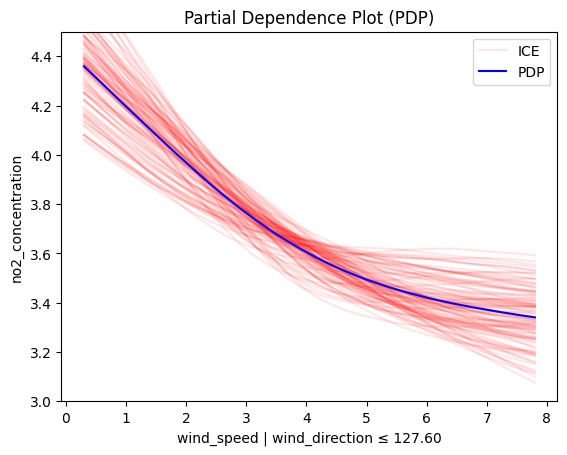

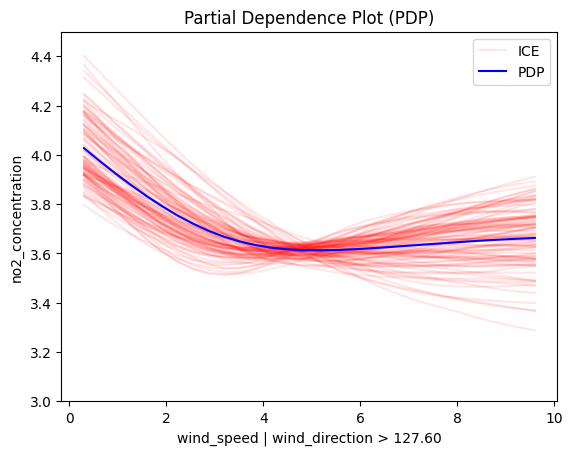

In [32]:
for node_idx in [1, 4]:
    regional_pdp.plot(feature=foi, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

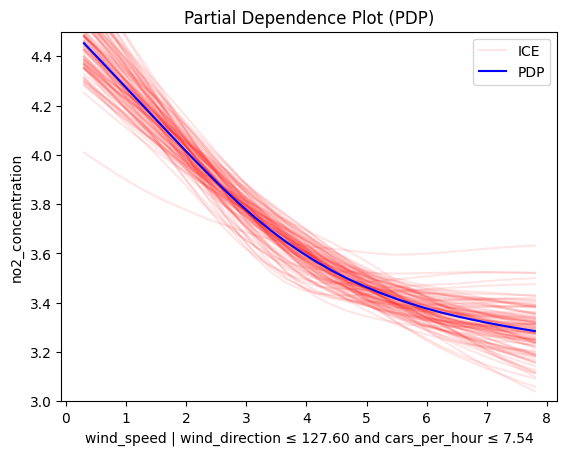

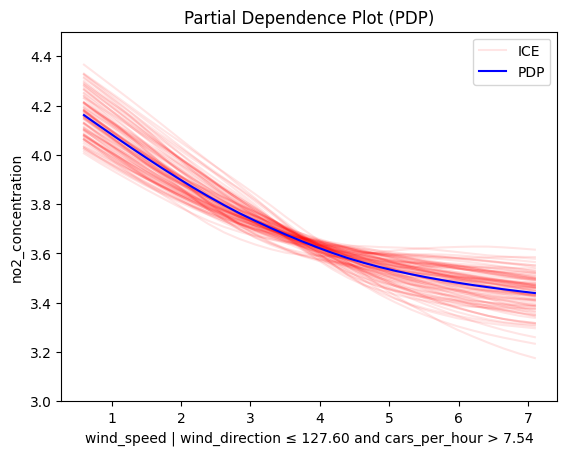

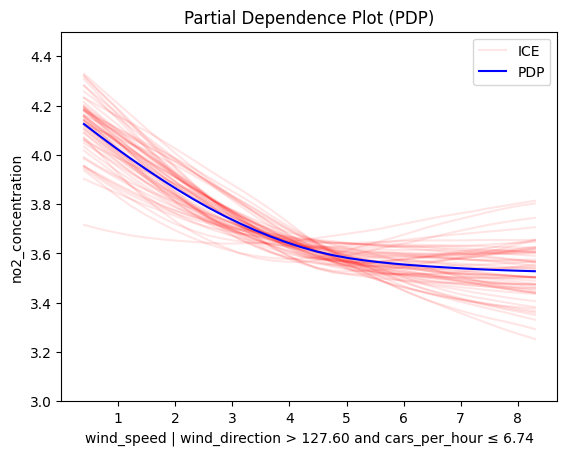

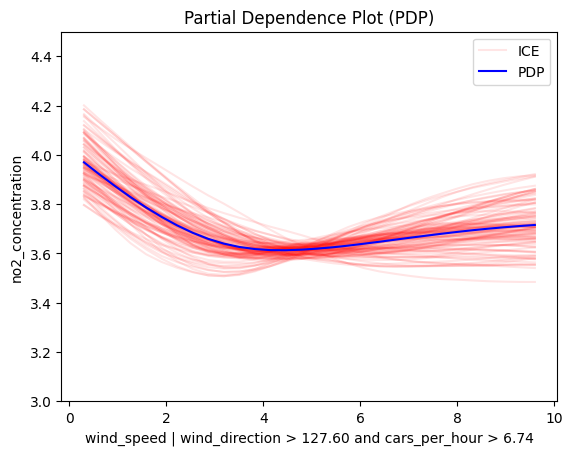

In [33]:
for node_idx in [2, 3, 5, 6]:
    regional_pdp.plot(feature=foi, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

### RegionalRHALE

In [18]:
regional_rhale = effector.RegionalRHALE(data=X_train.to_numpy(), model=model_forward, model_jac=model_jac, feature_names=feature_names, target_name=target_name)
regional_rhale.summary(features=foi, scale_x_list=scale_x_list)

100%|██████████| 1/1 [00:00<00:00,  1.77it/s]



Feature 2 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
wind_speed 🔹 [id: 0 | heter: 0.01 | inst: 400 | w: 1.00]
    wind_direction ≤ 127.60 🔹 [id: 1 | heter: 0.01 | inst: 210 | w: 0.53]
        cars_per_hour ≤ 7.34 🔹 [id: 2 | heter: 0.01 | inst: 114 | w: 0.28]
        cars_per_hour > 7.34 🔹 [id: 3 | heter: 0.00 | inst: 96 | w: 0.24]
    wind_direction > 127.60 🔹 [id: 4 | heter: 0.01 | inst: 190 | w: 0.47]
        cars_per_hour ≤ 6.94 🔹 [id: 5 | heter: 0.00 | inst: 63 | w: 0.16]
        cars_per_hour > 6.94 🔹 [id: 6 | heter: 0.00 | inst: 127 | w: 0.32]
--------------------------------------------------
Feature 2 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.01
    Level 1🔹heter: 0.01 | 🔻0.01 (58.65%)
        Level 2🔹heter: 0.00 | 🔻0.00 (38.41%)




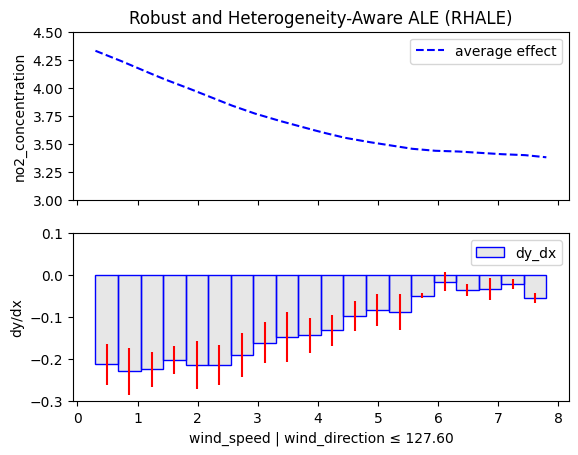

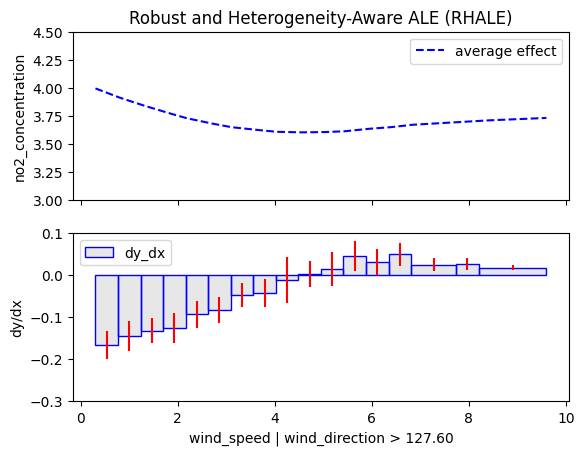

In [34]:
regional_rhale.plot(feature=foi, node_idx=1, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits, dy_limits=dy_limits)
regional_rhale.plot(feature=foi, node_idx=4, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits, dy_limits=dy_limits)

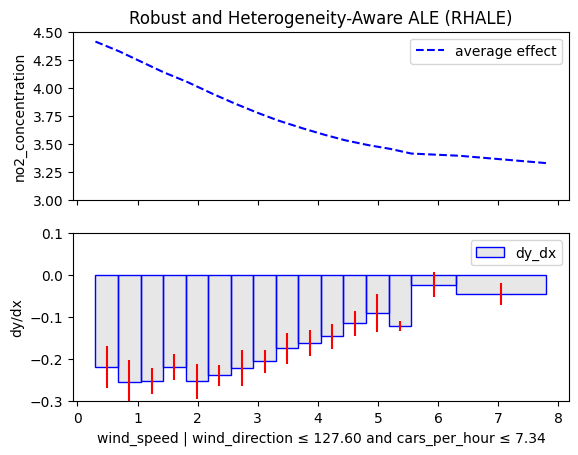

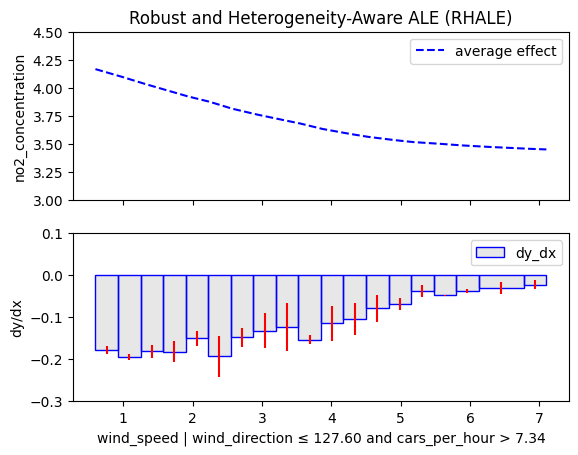

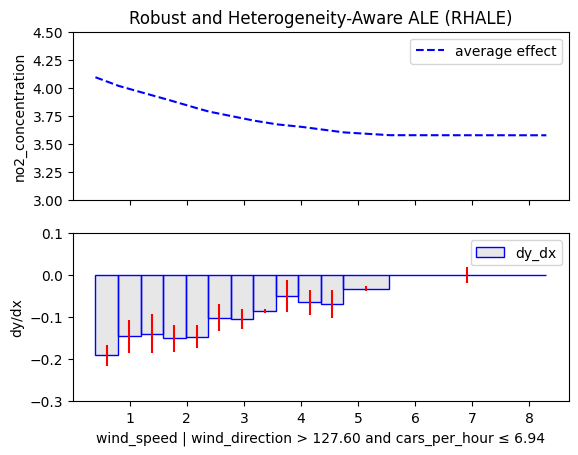

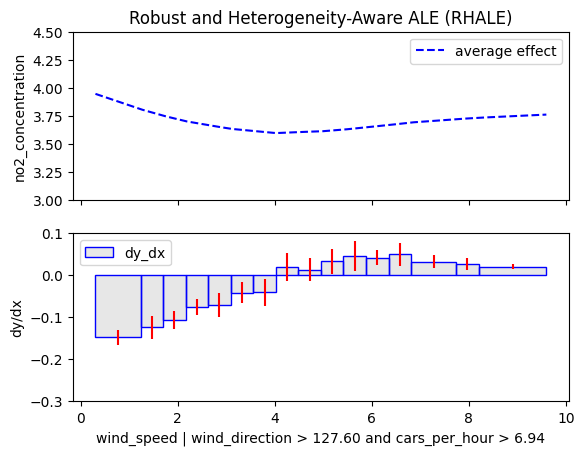

In [36]:
for node_idx in [2, 3,5,6]:
    regional_rhale.plot(feature=foi, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits, dy_limits=dy_limits)

### Regional SHAP-DP

In [37]:
regional_shap_dp = effector.RegionalShapDP(data=X_train.to_numpy(), model=model_forward, feature_names=feature_names, nof_instances=500, target_name=target_name)
regional_shap_dp.summary(features=foi, scale_x_list=scale_x_list)

ExactExplainer explainer: 401it [00:45,  6.98it/s]
100%|██████████| 1/1 [00:46<00:00, 46.10s/it]



Feature 2 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
wind_speed 🔹 [id: 0 | heter: 0.01 | inst: 400 | w: 1.00]
    wind_direction ≤ 145.40 🔹 [id: 1 | heter: 0.00 | inst: 213 | w: 0.53]
        cars_per_hour ≤ 7.54 🔹 [id: 2 | heter: 0.00 | inst: 125 | w: 0.31]
        cars_per_hour > 7.54 🔹 [id: 3 | heter: 0.00 | inst: 88 | w: 0.22]
    wind_direction > 145.40 🔹 [id: 4 | heter: 0.00 | inst: 187 | w: 0.47]
        cars_per_hour ≤ 6.94 🔹 [id: 5 | heter: 0.00 | inst: 62 | w: 0.15]
        cars_per_hour > 6.94 🔹 [id: 6 | heter: 0.00 | inst: 125 | w: 0.31]
--------------------------------------------------
Feature 2 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.01
    Level 1🔹heter: 0.00 | 🔻0.01 (69.82%)
        Level 2🔹heter: 0.00 | 🔻0.00 (51.33%)




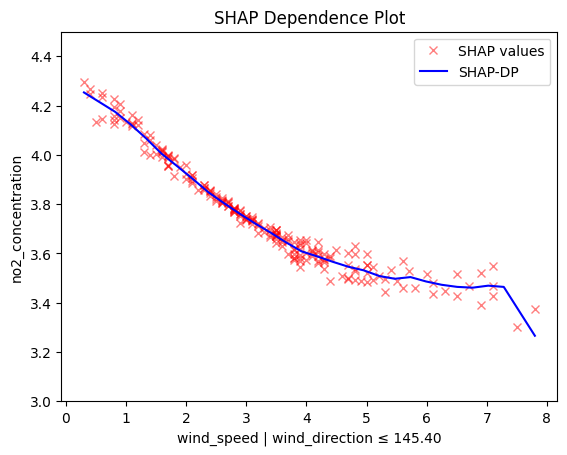

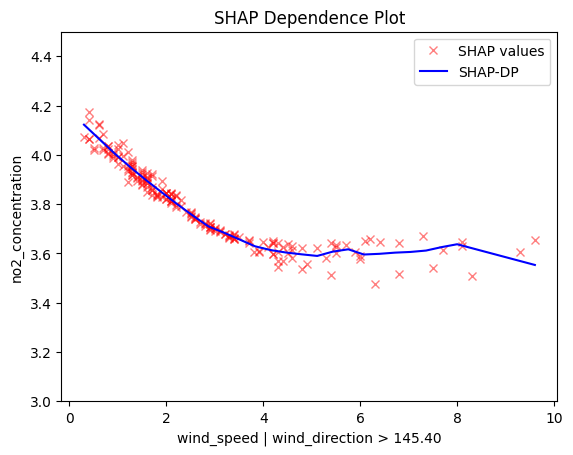

In [38]:
for node_idx in [1, 4]:
    regional_shap_dp.plot(feature=foi, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

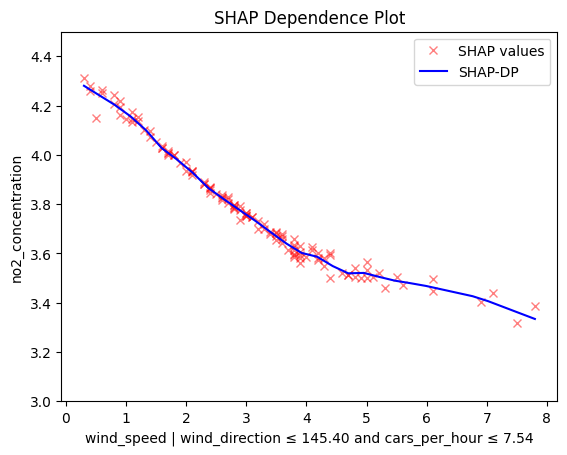

/Users/dimitriskyriakopoulos/Documents/ath/Effector/Code/effector-git/effector/effector/global_effect_shap.py:469: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.feature_effect["feature_" + str(feature)]["spline_std"](x))


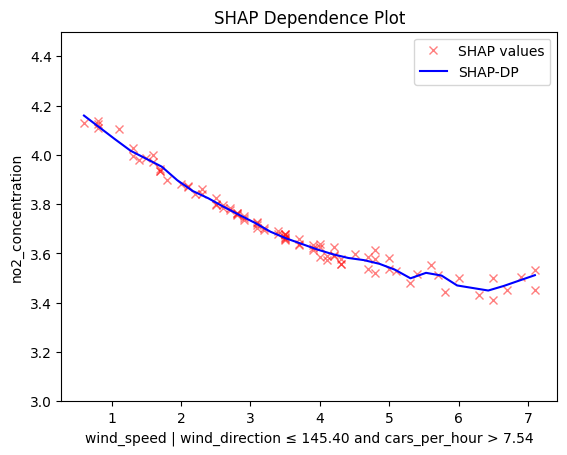

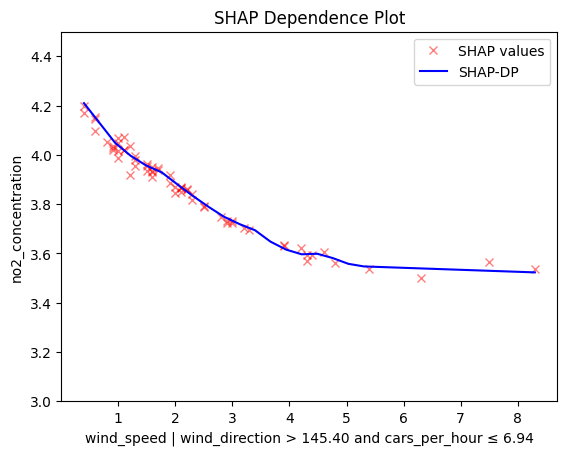

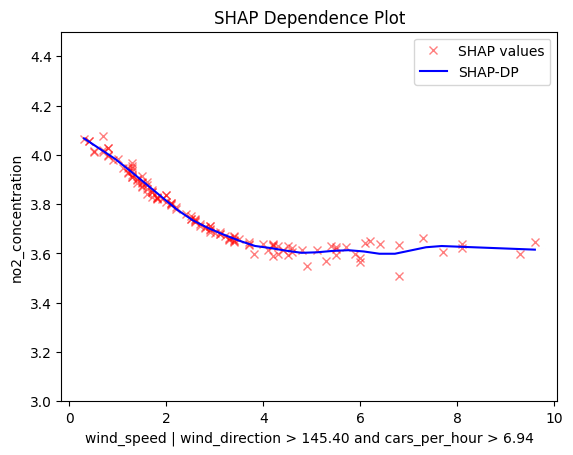

In [39]:
for node_idx in [2, 3,5,6]:
    regional_shap_dp.plot(feature=foi, node_idx=node_idx, centering=True, scale_x_list=scale_x_list, scale_y=scale_y, y_limits=y_limits)

### Conclusion  

Regional methods reveal two distinct patterns: 

- **Low wind directions (≤ ~127–145°):**, the dispersion appears more effective
- **High wind directions (> ~127–145°):**, NO₂ remains steady or even slightly increases with stronger winds. This may be due to topographical blocking or pollutant recirculation depending on the local layout.

Diving deeper we observe that the relationship between `wind speed` and NO₂ further depends on `traffic volume`, revealing interaction effects:

- At **low wind directions:**:
  - If **cars/hour ≤ 8**, the drop in NO₂ with wind is more pronounced.
  - If **cars/hour > 8**, the drop becomes smoother, suggesting higher emissions dampen the wind’s dispersive power.
- At **high wind directions:** 
  - If **cars/hour ≤ 7**, NO₂ still decreases slightly even with higher wind.
  - If **cars/hour > 7**, the trend either flattens (SHAP-DP) or shows a slight increase (PDP, rHALE), potentially due to congestion-induced buildup or ineffective dispersal under certain wind conditions.
